# Replace star sampling with sampling ranges of L M and T

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform
#plt.style.use('paper')
from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON

In [14]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [15]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [16]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (just over Nep. Lowest val in Baraffe)
    Mmax = 5*318 # Mearth (5 MJup. Highest in Baraffe)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler2():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def age_sampler():
    return loguniform(1.1e7, 1e8) * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Sample

In [17]:
IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 200 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 286 pc


In [18]:
def sample(M0, dopt, lamb, star_type):
    if star_type == "G2":
        star = swarms.Star(1.*LSUN, 1.*MSUN, 5780, d=0)
    elif star_type == "M0":
        star = swarms.Star(0.072*LSUN, 0.60*MSUN, 3800, d=0)
    elif star_type == "K5":
        star = swarms.Star(0.16*LSUN, 0.69*MSUN, 4410, d=0)
    elif star_type == "G5":
        star = swarms.Star(0.79*LSUN, 0.93*MSUN, 5610, d=0)
    elif star_type == "F5":
        star = swarms.Star(2.5*LSUN, 1.3*MSUN, 6540, d=0)
    elif star_type == "F0":
        star = swarms.Star(5.2*LSUN, 1.4*MSUN, 7420, d=0)
    else:
        print("randomizing")
        star = star_sampler()
    star.d = distance_sampler(mean=dopt, std=dopt/2.)
    if star.Imag < 0 or star.Imag > 12:
        #print(star.Imag)
        return sample(M0, dopt, lamb, star_type) # do it again
    age = 11e6 * YEAR # age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, dopt, lamb, star_type) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dt=Dt, Dmax=Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, stranding=True, Dmin_min=lamb, age=age)
    CRscatSwarm = swarm.computeCRscat(g)
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    print("Mtot: {0:.2e} \t Tcol: {1:.2e} \t tnleft: {2:.2e} \t Tcol0: {3:.2e} \t 1/(Mplt^0.24 * apl^4.13): {4:.2e}".format(swarm.swarm.M0/MEARTH, swarm.computeTcol()/YEAR, swarm.tnleft/YEAR, swarm.Tcol0, 1./((swarm.planet.M/MEARTH)**0.24 * (swarm.planet.a/AU)**4.13)))
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [19]:
%%time
seed(0)
M1 = 1*MEARTH
dopt1 = 60 * PC
star_type1 = "G5"
Nsamples = 300
CRscatSwarm1, CRPlanet1, a1, d1, Mplt1, Imag1 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a1[i], d1[i], Mplt1[i], Imag1[i] = sample(M1, dopt1, lamb, star_type1)

Mtot: 6.45e-01 	 Tcol: 3.09e+07 	 tnleft: 1.51e+12 	 Tcol0: 6.29e+14 	 1/(Mplt^0.24 * apl^4.13): 2.84e-09
Mtot: 1.30e-03 	 Tcol: 1.10e+07 	 tnleft: 5.29e+10 	 Tcol0: 4.51e+11 	 1/(Mplt^0.24 * apl^4.13): 6.28e-07
Mtot: 1.80e-03 	 Tcol: 1.10e+07 	 tnleft: 1.67e+12 	 Tcol0: 6.25e+11 	 1/(Mplt^0.24 * apl^4.13): 2.91e-07
Mtot: 9.35e-01 	 Tcol: 1.69e+08 	 tnleft: 1.71e+12 	 Tcol0: 4.98e+15 	 1/(Mplt^0.24 * apl^4.13): 3.00e-09
Mtot: 6.59e-01 	 Tcol: 3.23e+07 	 tnleft: 9.04e+10 	 Tcol0: 6.71e+14 	 1/(Mplt^0.24 * apl^4.13): 2.46e-08
Mtot: 6.86e-04 	 Tcol: 1.10e+07 	 tnleft: 9.72e+08 	 Tcol0: 2.38e+11 	 1/(Mplt^0.24 * apl^4.13): 7.83e-06
Mtot: 2.54e-02 	 Tcol: 1.13e+07 	 tnleft: 2.65e+13 	 Tcol0: 9.06e+12 	 1/(Mplt^0.24 * apl^4.13): 4.67e-09
Mtot: 4.96e-01 	 Tcol: 2.18e+07 	 tnleft: 4.39e+11 	 Tcol0: 3.41e+14 	 1/(Mplt^0.24 * apl^4.13): 6.62e-09
Mtot: 1.53e-05 	 Tcol: 1.10e+07 	 tnleft: 2.21e+08 	 Tcol0: 5.30e+09 	 1/(Mplt^0.24 * apl^4.13): 9.87e-05
Mtot: 1.73e-03 	 Tcol: 1.10e+07 	 tnleft: 1.53

Mtot: 4.70e-03 	 Tcol: 1.11e+07 	 tnleft: 1.66e+12 	 Tcol0: 1.64e+12 	 1/(Mplt^0.24 * apl^4.13): 1.44e-08
Mtot: 2.58e-04 	 Tcol: 1.10e+07 	 tnleft: 3.41e+09 	 Tcol0: 8.97e+10 	 1/(Mplt^0.24 * apl^4.13): 7.88e-06
Mtot: 9.48e-05 	 Tcol: 1.10e+07 	 tnleft: 9.09e+10 	 Tcol0: 3.29e+10 	 1/(Mplt^0.24 * apl^4.13): 1.07e-06
Mtot: 1.72e-04 	 Tcol: 1.10e+07 	 tnleft: 3.05e+11 	 Tcol0: 5.98e+10 	 1/(Mplt^0.24 * apl^4.13): 1.44e-07
Mtot: 1.76e-01 	 Tcol: 1.33e+07 	 tnleft: 1.06e+12 	 Tcol0: 7.40e+13 	 1/(Mplt^0.24 * apl^4.13): 1.36e-08
Mtot: 1.20e-04 	 Tcol: 1.10e+07 	 tnleft: 1.43e+11 	 Tcol0: 4.17e+10 	 1/(Mplt^0.24 * apl^4.13): 1.15e-06
Mtot: 2.23e-06 	 Tcol: 1.10e+07 	 tnleft: 1.90e+09 	 Tcol0: 7.73e+08 	 1/(Mplt^0.24 * apl^4.13): 1.05e-04
Mtot: 2.14e-02 	 Tcol: 1.12e+07 	 tnleft: 1.89e+10 	 Tcol0: 7.58e+12 	 1/(Mplt^0.24 * apl^4.13): 1.57e-06
Mtot: 1.80e-03 	 Tcol: 1.10e+07 	 tnleft: 3.50e+10 	 Tcol0: 6.26e+11 	 1/(Mplt^0.24 * apl^4.13): 5.27e-07
Mtot: 6.24e-02 	 Tcol: 1.17e+07 	 tnleft: 7.06

Mtot: 3.29e-01 	 Tcol: 1.64e+07 	 tnleft: 1.47e+10 	 Tcol0: 1.70e+14 	 1/(Mplt^0.24 * apl^4.13): 4.37e-08
Mtot: 1.54e-03 	 Tcol: 1.10e+07 	 tnleft: 2.86e+13 	 Tcol0: 5.36e+11 	 1/(Mplt^0.24 * apl^4.13): 3.20e-08
Mtot: 4.52e-05 	 Tcol: 1.10e+07 	 tnleft: 2.35e+09 	 Tcol0: 1.57e+10 	 1/(Mplt^0.24 * apl^4.13): 5.70e-06
Mtot: 1.65e-02 	 Tcol: 1.12e+07 	 tnleft: 5.90e+09 	 Tcol0: 5.83e+12 	 1/(Mplt^0.24 * apl^4.13): 7.68e-07
Mtot: 2.37e-09 	 Tcol: 4.48e+06 	 tnleft: 9.33e+04 	 Tcol0: 1.10e+08 	 1/(Mplt^0.24 * apl^4.13): 7.61e-02
Mtot: 2.41e-10 	 Tcol: 4.47e+06 	 tnleft: 6.46e+04 	 Tcol0: 1.92e+07 	 1/(Mplt^0.24 * apl^4.13): 5.45e-02
Mtot: 8.51e-05 	 Tcol: 1.10e+07 	 tnleft: 1.15e+10 	 Tcol0: 2.95e+10 	 1/(Mplt^0.24 * apl^4.13): 7.63e-07
Mtot: 2.50e-08 	 Tcol: 1.10e+07 	 tnleft: 3.49e+08 	 Tcol0: 8.68e+06 	 1/(Mplt^0.24 * apl^4.13): 6.79e-04
Mtot: 1.05e-03 	 Tcol: 1.10e+07 	 tnleft: 1.05e+11 	 Tcol0: 3.66e+11 	 1/(Mplt^0.24 * apl^4.13): 1.37e-07
Mtot: 3.19e-05 	 Tcol: 1.10e+07 	 tnleft: 7.39

Mtot: 2.05e-03 	 Tcol: 1.10e+07 	 tnleft: 3.98e+08 	 Tcol0: 7.12e+11 	 1/(Mplt^0.24 * apl^4.13): 1.61e-05
Mtot: 1.02e-03 	 Tcol: 1.10e+07 	 tnleft: 1.45e+12 	 Tcol0: 3.55e+11 	 1/(Mplt^0.24 * apl^4.13): 1.11e-07
Mtot: 3.48e-04 	 Tcol: 1.10e+07 	 tnleft: 1.21e+12 	 Tcol0: 1.21e+11 	 1/(Mplt^0.24 * apl^4.13): 2.75e-07
Mtot: 4.86e-04 	 Tcol: 1.10e+07 	 tnleft: 6.05e+08 	 Tcol0: 1.69e+11 	 1/(Mplt^0.24 * apl^4.13): 2.21e-06
Mtot: 1.59e-04 	 Tcol: 1.10e+07 	 tnleft: 9.07e+11 	 Tcol0: 5.52e+10 	 1/(Mplt^0.24 * apl^4.13): 3.19e-07
Mtot: 9.38e-05 	 Tcol: 1.10e+07 	 tnleft: 4.20e+07 	 Tcol0: 3.25e+10 	 1/(Mplt^0.24 * apl^4.13): 5.30e-05
Mtot: 3.43e-05 	 Tcol: 1.10e+07 	 tnleft: 1.07e+09 	 Tcol0: 1.19e+10 	 1/(Mplt^0.24 * apl^4.13): 3.19e-06
Mtot: 1.35e-02 	 Tcol: 1.12e+07 	 tnleft: 1.25e+12 	 Tcol0: 4.74e+12 	 1/(Mplt^0.24 * apl^4.13): 5.20e-08
Mtot: 2.78e-03 	 Tcol: 1.10e+07 	 tnleft: 1.01e+11 	 Tcol0: 9.66e+11 	 1/(Mplt^0.24 * apl^4.13): 2.83e-07
Mtot: 2.23e-01 	 Tcol: 1.42e+07 	 tnleft: 5.82

In [20]:
%%time
seed(0)
M2 = 0.01*MEARTH
dopt2 = 60 * PC
star_type2 = "M0"
Nsamples = 300
CRscatSwarm2, CRPlanet2, a2, d2, Mplt2, Imag2 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm2[i], CRPlanet2[i], a2[i], d2[i], Mplt2[i], Imag2[i] = sample(M2, dopt2, lamb, star_type2)

Mtot: 7.54e-03 	 Tcol: 4.48e+07 	 tnleft: 2.56e+10 	 Tcol0: 1.07e+15 	 1/(Mplt^0.24 * apl^4.13): 3.04e-07
Mtot: 7.91e-04 	 Tcol: 1.19e+07 	 tnleft: 3.50e+10 	 Tcol0: 2.98e+13 	 1/(Mplt^0.24 * apl^4.13): 1.72e-06
Mtot: 8.59e-05 	 Tcol: 1.11e+07 	 tnleft: 8.01e+10 	 Tcol0: 3.00e+12 	 1/(Mplt^0.24 * apl^4.13): 1.09e-05
Mtot: 9.93e-03 	 Tcol: 1.58e+09 	 tnleft: 1.70e+11 	 Tcol0: 4.95e+16 	 1/(Mplt^0.24 * apl^4.13): 5.46e-08
Mtot: 1.00e-02 	 Tcol: 2.42e+10 	 tnleft: 1.03e+12 	 Tcol0: 7.62e+17 	 1/(Mplt^0.24 * apl^4.13): 4.00e-09
Mtot: 2.95e-03 	 Tcol: 1.56e+07 	 tnleft: 5.92e+09 	 Tcol0: 1.45e+14 	 1/(Mplt^0.24 * apl^4.13): 2.36e-06
Mtot: 8.97e-03 	 Tcol: 1.07e+08 	 tnleft: 8.85e+13 	 Tcol0: 3.03e+15 	 1/(Mplt^0.24 * apl^4.13): 2.54e-09
Mtot: 9.98e-03 	 Tcol: 5.40e+09 	 tnleft: 2.19e+12 	 Tcol0: 1.70e+17 	 1/(Mplt^0.24 * apl^4.13): 2.46e-09
Mtot: 5.31e-04 	 Tcol: 1.16e+07 	 tnleft: 8.13e+09 	 Tcol0: 1.94e+13 	 1/(Mplt^0.24 * apl^4.13): 4.96e-06
Mtot: 5.20e-03 	 Tcol: 2.29e+07 	 tnleft: 9.51

Mtot: 7.88e-04 	 Tcol: 1.19e+07 	 tnleft: 5.41e+10 	 Tcol0: 2.97e+13 	 1/(Mplt^0.24 * apl^4.13): 1.20e-06
Mtot: 4.93e-03 	 Tcol: 2.17e+07 	 tnleft: 3.41e+12 	 Tcol0: 3.37e+14 	 1/(Mplt^0.24 * apl^4.13): 1.29e-08
Mtot: 3.81e-03 	 Tcol: 1.78e+07 	 tnleft: 8.12e+10 	 Tcol0: 2.14e+14 	 1/(Mplt^0.24 * apl^4.13): 6.06e-07
Mtot: 4.69e-05 	 Tcol: 1.11e+07 	 tnleft: 4.52e+10 	 Tcol0: 1.64e+12 	 1/(Mplt^0.24 * apl^4.13): 3.94e-06
Mtot: 8.35e-09 	 Tcol: 1.10e+07 	 tnleft: 1.48e+07 	 Tcol0: 2.90e+08 	 1/(Mplt^0.24 * apl^4.13): 5.39e-03
Mtot: 1.22e-03 	 Tcol: 1.25e+07 	 tnleft: 6.88e+09 	 Tcol0: 4.81e+13 	 1/(Mplt^0.24 * apl^4.13): 3.81e-06
Mtot: 1.07e-04 	 Tcol: 1.11e+07 	 tnleft: 1.29e+11 	 Tcol0: 3.76e+12 	 1/(Mplt^0.24 * apl^4.13): 2.33e-06
Mtot: 4.21e-06 	 Tcol: 1.10e+07 	 tnleft: 3.58e+09 	 Tcol0: 1.46e+11 	 1/(Mplt^0.24 * apl^4.13): 1.02e-04
Mtot: 5.43e-03 	 Tcol: 2.40e+07 	 tnleft: 1.03e+10 	 Tcol0: 4.12e+14 	 1/(Mplt^0.24 * apl^4.13): 5.22e-06
Mtot: 3.28e-03 	 Tcol: 1.64e+07 	 tnleft: 9.48

Mtot: 3.95e-03 	 Tcol: 1.82e+07 	 tnleft: 2.51e+11 	 Tcol0: 2.27e+14 	 1/(Mplt^0.24 * apl^4.13): 7.70e-07
Mtot: 6.75e-03 	 Tcol: 3.38e+07 	 tnleft: 2.10e+10 	 Tcol0: 7.21e+14 	 1/(Mplt^0.24 * apl^4.13): 1.98e-06
Mtot: 9.43e-03 	 Tcol: 1.91e+08 	 tnleft: 6.37e+10 	 Tcol0: 5.69e+15 	 1/(Mplt^0.24 * apl^4.13): 9.78e-08
Mtot: 9.42e-03 	 Tcol: 1.89e+08 	 tnleft: 4.87e+09 	 Tcol0: 5.62e+15 	 1/(Mplt^0.24 * apl^4.13): 2.40e-07
Mtot: 1.30e-03 	 Tcol: 1.26e+07 	 tnleft: 2.77e+13 	 Tcol0: 5.20e+13 	 1/(Mplt^0.24 * apl^4.13): 6.05e-08
Mtot: 5.25e-05 	 Tcol: 1.11e+07 	 tnleft: 2.75e+09 	 Tcol0: 1.83e+12 	 1/(Mplt^0.24 * apl^4.13): 8.91e-06
Mtot: 7.36e-04 	 Tcol: 1.19e+07 	 tnleft: 2.79e+08 	 Tcol0: 2.76e+13 	 1/(Mplt^0.24 * apl^4.13): 2.93e-05
Mtot: 8.05e-03 	 Tcol: 5.63e+07 	 tnleft: 1.21e+10 	 Tcol0: 1.43e+15 	 1/(Mplt^0.24 * apl^4.13): 1.09e-06
Mtot: 2.24e-03 	 Tcol: 1.42e+07 	 tnleft: 3.36e+09 	 Tcol0: 1.00e+14 	 1/(Mplt^0.24 * apl^4.13): 1.93e-06
Mtot: 2.04e-05 	 Tcol: 1.10e+07 	 tnleft: 2.77

Mtot: 7.23e-03 	 Tcol: 3.97e+07 	 tnleft: 2.15e+12 	 Tcol0: 9.06e+14 	 1/(Mplt^0.24 * apl^4.13): 4.84e-08
Mtot: 5.35e-04 	 Tcol: 1.16e+07 	 tnleft: 7.54e+09 	 Tcol0: 1.96e+13 	 1/(Mplt^0.24 * apl^4.13): 2.36e-06
Mtot: 1.16e-07 	 Tcol: 1.10e+07 	 tnleft: 4.51e+08 	 Tcol0: 4.03e+09 	 1/(Mplt^0.24 * apl^4.13): 1.93e-03
Mtot: 6.82e-03 	 Tcol: 3.46e+07 	 tnleft: 2.80e+09 	 Tcol0: 7.44e+14 	 1/(Mplt^0.24 * apl^4.13): 3.79e-06
Mtot: 2.48e-03 	 Tcol: 1.46e+07 	 tnleft: 3.30e+11 	 Tcol0: 1.14e+14 	 1/(Mplt^0.24 * apl^4.13): 1.03e-07
Mtot: 2.67e-03 	 Tcol: 1.50e+07 	 tnleft: 5.61e+11 	 Tcol0: 1.26e+14 	 1/(Mplt^0.24 * apl^4.13): 4.80e-07
Mtot: 4.24e-03 	 Tcol: 1.91e+07 	 tnleft: 6.22e+09 	 Tcol0: 2.56e+14 	 1/(Mplt^0.24 * apl^4.13): 6.92e-07
Mtot: 5.96e-03 	 Tcol: 2.72e+07 	 tnleft: 2.86e+09 	 Tcol0: 5.12e+14 	 1/(Mplt^0.24 * apl^4.13): 4.14e-06
Mtot: 8.15e-07 	 Tcol: 1.10e+07 	 tnleft: 1.16e+09 	 Tcol0: 2.83e+10 	 1/(Mplt^0.24 * apl^4.13): 2.53e-04
Mtot: 3.92e-05 	 Tcol: 1.10e+07 	 tnleft: 1.37

ValueError: swarms.sizeDistribution initialized with a maximum size Dc (2.3e+00) < Dt (2.3e+00). Implementation assumes Dc > Dt.

In [21]:
%%time
seed(0)
M4 = 1.e-4*MEARTH
star_type4 = "M0"
dopt4 = 60 * PC
Nsamples = 300
CRscatSwarm4, CRPlanet4, a4, d4, Mplt4, Imag4 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm4[i], CRPlanet4[i], a4[i], d4[i], Mplt4[i], Imag4[i] = sample(M4, dopt4, lamb, star_type4)

Mtot: 1.00e-04 	 Tcol: 4.03e+11 	 tnleft: 3.06e+12 	 Tcol0: 1.27e+19 	 1/(Mplt^0.24 * apl^4.13): 2.58e-09
Mtot: 7.45e-05 	 Tcol: 4.31e+07 	 tnleft: 1.19e+10 	 Tcol0: 1.01e+15 	 1/(Mplt^0.24 * apl^4.13): 5.10e-06
Mtot: 9.81e-05 	 Tcol: 5.69e+08 	 tnleft: 4.69e+12 	 Tcol0: 1.76e+16 	 1/(Mplt^0.24 * apl^4.13): 1.87e-07
Mtot: 1.00e-04 	 Tcol: 1.37e+11 	 tnleft: 1.49e+11 	 Tcol0: 4.33e+18 	 1/(Mplt^0.24 * apl^4.13): 6.25e-08
Mtot: 1.00e-04 	 Tcol: 1.42e+12 	 tnleft: 6.04e+11 	 Tcol0: 4.49e+19 	 1/(Mplt^0.24 * apl^4.13): 6.79e-09
Mtot: 6.59e-05 	 Tcol: 3.22e+07 	 tnleft: 2.73e+08 	 Tcol0: 6.70e+14 	 1/(Mplt^0.24 * apl^4.13): 5.04e-05
Mtot: 9.88e-05 	 Tcol: 9.02e+08 	 tnleft: 8.21e+12 	 Tcol0: 2.81e+16 	 1/(Mplt^0.24 * apl^4.13): 2.72e-08
Mtot: 9.99e-05 	 Tcol: 1.24e+10 	 tnleft: 5.03e+10 	 Tcol0: 3.91e+17 	 1/(Mplt^0.24 * apl^4.13): 1.06e-07
Mtot: 2.39e-05 	 Tcol: 1.45e+07 	 tnleft: 4.57e+08 	 Tcol0: 1.09e+14 	 1/(Mplt^0.24 * apl^4.13): 8.79e-05
Mtot: 9.90e-05 	 Tcol: 1.13e+09 	 tnleft: 8.96

ValueError: swarms.sizeDistribution initialized with a maximum size Dc (1.6e+00) < Dt (1.6e+00). Implementation assumes Dc > Dt.

In [22]:
%%time
seed(0)
M6 = 1.e-6*MEARTH
dopt6 = 60 * PC
star_type6 = "M0"
Nsamples = 300
CRscatSwarm6, CRPlanet6, a6, d6, Mplt6, Imag6 = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm6[i], CRPlanet6[i], a6[i], d6[i], Mplt6[i], Imag6[i] = sample(M6, dopt6, lamb, star_type6)

Mtot: 1.00e-06 	 Tcol: 6.95e+12 	 tnleft: 5.27e+11 	 Tcol0: 2.19e+20 	 1/(Mplt^0.24 * apl^4.13): 1.48e-08
Mtot: 9.79e-07 	 Tcol: 5.33e+08 	 tnleft: 1.93e+09 	 Tcol0: 1.65e+16 	 1/(Mplt^0.24 * apl^4.13): 3.13e-05
Mtot: 9.99e-07 	 Tcol: 1.56e+10 	 tnleft: 1.31e+12 	 Tcol0: 4.91e+17 	 1/(Mplt^0.24 * apl^4.13): 6.71e-07
Mtot: 1.00e-06 	 Tcol: 5.16e+10 	 tnleft: 5.59e+08 	 Tcol0: 1.63e+18 	 1/(Mplt^0.24 * apl^4.13): 1.66e-05
Mtot: 1.00e-06 	 Tcol: 1.00e+13 	 tnleft: 4.26e+10 	 Tcol0: 3.16e+20 	 1/(Mplt^0.24 * apl^4.13): 9.58e-08
Mtot: 9.65e-07 	 Tcol: 3.19e+08 	 tnleft: 3.96e+07 	 Tcol0: 9.70e+15 	 1/(Mplt^0.24 * apl^4.13): 3.47e-04
Mtot: 1.00e-06 	 Tcol: 4.78e+10 	 tnleft: 4.40e+12 	 Tcol0: 1.51e+18 	 1/(Mplt^0.24 * apl^4.13): 5.08e-08
Mtot: 1.00e-06 	 Tcol: 8.66e+13 	 tnleft: 3.52e+12 	 Tcol0: 2.73e+21 	 1/(Mplt^0.24 * apl^4.13): 1.51e-09
Mtot: 9.98e-07 	 Tcol: 5.18e+09 	 tnleft: 6.81e+09 	 Tcol0: 1.63e+17 	 1/(Mplt^0.24 * apl^4.13): 5.89e-06
Mtot: 1.00e-06 	 Tcol: 7.85e+10 	 tnleft: 6.26

Mtot: 1.00e-06 	 Tcol: 1.13e+11 	 tnleft: 3.61e+12 	 Tcol0: 3.57e+18 	 1/(Mplt^0.24 * apl^4.13): 1.21e-08
Mtot: 1.00e-06 	 Tcol: 1.29e+11 	 tnleft: 1.54e+11 	 Tcol0: 4.06e+18 	 1/(Mplt^0.24 * apl^4.13): 3.24e-07
Mtot: 7.45e-08 	 Tcol: 1.19e+07 	 tnleft: 7.71e+07 	 Tcol0: 2.79e+13 	 1/(Mplt^0.24 * apl^4.13): 2.30e-03
Mtot: 9.88e-07 	 Tcol: 8.81e+08 	 tnleft: 1.40e+11 	 Tcol0: 2.74e+16 	 1/(Mplt^0.24 * apl^4.13): 5.75e-07
Mtot: 1.00e-06 	 Tcol: 1.07e+12 	 tnleft: 4.82e+11 	 Tcol0: 3.37e+19 	 1/(Mplt^0.24 * apl^4.13): 5.49e-08
Mtot: 1.00e-06 	 Tcol: 5.28e+10 	 tnleft: 5.70e+12 	 Tcol0: 1.66e+18 	 1/(Mplt^0.24 * apl^4.13): 5.35e-08
Mtot: 9.78e-07 	 Tcol: 4.99e+08 	 tnleft: 3.77e+10 	 Tcol0: 1.54e+16 	 1/(Mplt^0.24 * apl^4.13): 9.64e-06
Mtot: 9.71e-07 	 Tcol: 3.77e+08 	 tnleft: 2.89e+07 	 Tcol0: 1.16e+16 	 1/(Mplt^0.24 * apl^4.13): 1.86e-03
Mtot: 9.93e-07 	 Tcol: 1.62e+09 	 tnleft: 2.84e+09 	 Tcol0: 5.08e+16 	 1/(Mplt^0.24 * apl^4.13): 1.16e-05
Mtot: 1.00e-06 	 Tcol: 3.31e+11 	 tnleft: 3.19

Mtot: 1.00e-06 	 Tcol: 4.50e+12 	 tnleft: 4.13e+11 	 Tcol0: 1.42e+20 	 1/(Mplt^0.24 * apl^4.13): 1.01e-07
Mtot: 1.00e-06 	 Tcol: 4.07e+12 	 tnleft: 1.44e+11 	 Tcol0: 1.28e+20 	 1/(Mplt^0.24 * apl^4.13): 4.33e-08
Mtot: 1.00e-06 	 Tcol: 8.87e+13 	 tnleft: 2.42e+11 	 Tcol0: 2.80e+21 	 1/(Mplt^0.24 * apl^4.13): 4.85e-09
Mtot: 1.00e-06 	 Tcol: 3.87e+10 	 tnleft: 6.49e+13 	 Tcol0: 1.22e+18 	 1/(Mplt^0.24 * apl^4.13): 2.59e-08
Mtot: 9.48e-07 	 Tcol: 2.13e+08 	 tnleft: 9.56e+08 	 Tcol0: 6.36e+15 	 1/(Mplt^0.24 * apl^4.13): 2.56e-05
Mtot: 1.00e-06 	 Tcol: 2.19e+12 	 tnleft: 6.99e+10 	 Tcol0: 6.91e+19 	 1/(Mplt^0.24 * apl^4.13): 1.18e-07
Mtot: 1.00e-06 	 Tcol: 4.30e+12 	 tnleft: 1.15e+11 	 Tcol0: 1.36e+20 	 1/(Mplt^0.24 * apl^4.13): 1.15e-07
Mtot: 9.99e-07 	 Tcol: 9.77e+09 	 tnleft: 1.03e+09 	 Tcol0: 3.08e+17 	 1/(Mplt^0.24 * apl^4.13): 6.23e-06
Mtot: 9.80e-07 	 Tcol: 5.39e+08 	 tnleft: 6.51e+09 	 Tcol0: 1.66e+16 	 1/(Mplt^0.24 * apl^4.13): 2.47e-06
Mtot: 5.65e-07 	 Tcol: 2.53e+07 	 tnleft: 1.82

Mtot: 1.00e-06 	 Tcol: 2.33e+12 	 tnleft: 2.77e+10 	 Tcol0: 7.35e+19 	 1/(Mplt^0.24 * apl^4.13): 3.81e-07
Mtot: 1.00e-06 	 Tcol: 4.38e+10 	 tnleft: 3.99e+11 	 Tcol0: 1.38e+18 	 1/(Mplt^0.24 * apl^4.13): 8.48e-08
Mtot: 1.00e-06 	 Tcol: 6.44e+10 	 tnleft: 9.04e+11 	 Tcol0: 2.03e+18 	 1/(Mplt^0.24 * apl^4.13): 2.96e-07
Mtot: 1.00e-06 	 Tcol: 3.02e+11 	 tnleft: 2.32e+10 	 Tcol0: 9.53e+18 	 1/(Mplt^0.24 * apl^4.13): 1.86e-07
Mtot: 1.00e-06 	 Tcol: 3.69e+10 	 tnleft: 6.50e+08 	 Tcol0: 1.16e+18 	 1/(Mplt^0.24 * apl^4.13): 1.83e-05
Mtot: 1.00e-06 	 Tcol: 3.63e+11 	 tnleft: 4.69e+13 	 Tcol0: 1.15e+19 	 1/(Mplt^0.24 * apl^4.13): 6.30e-09
Mtot: 1.10e-08 	 Tcol: 1.11e+07 	 tnleft: 3.86e+07 	 Tcol0: 3.86e+12 	 1/(Mplt^0.24 * apl^4.13): 1.54e-02
Mtot: 9.99e-07 	 Tcol: 1.27e+10 	 tnleft: 1.44e+09 	 Tcol0: 4.01e+17 	 1/(Mplt^0.24 * apl^4.13): 1.70e-06
Mtot: 1.00e-06 	 Tcol: 3.30e+11 	 tnleft: 1.71e+14 	 Tcol0: 1.04e+19 	 1/(Mplt^0.24 * apl^4.13): 3.07e-09
Mtot: 1.00e-06 	 Tcol: 2.18e+11 	 tnleft: 8.88

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


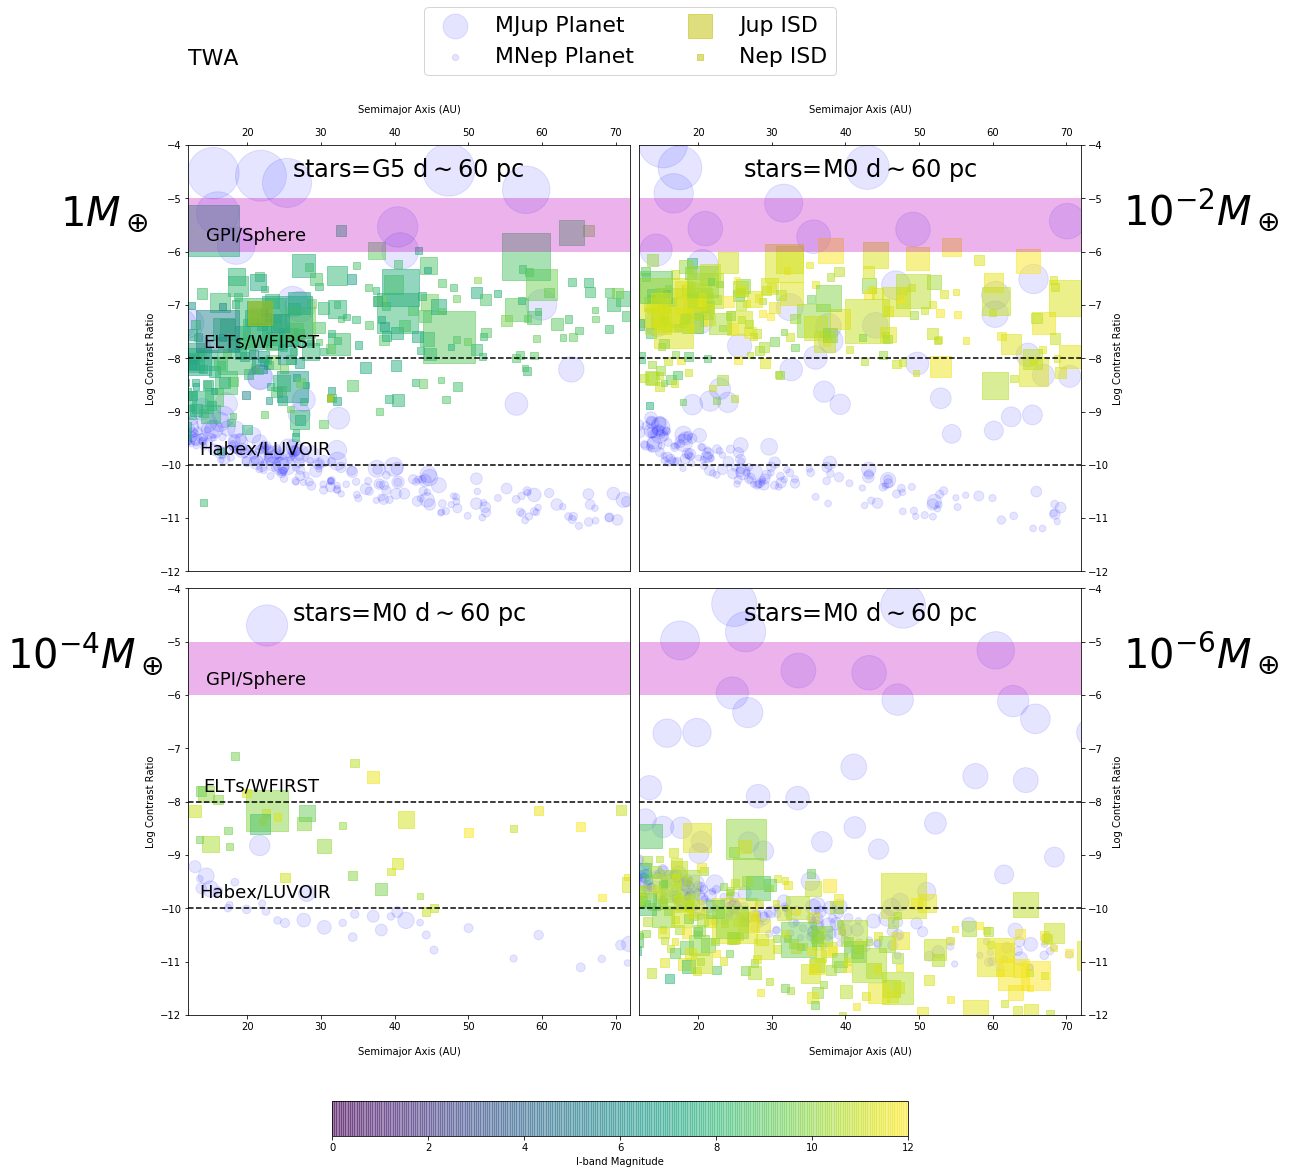

In [23]:
def plot(ax, a, logCRscatSwarm, logCRPlanet, Mplt, Imag, dopt):
    Mcut = 2*Mplt/MEARTH
    ax.scatter(a, logCRPlanet, c='b', vmax=12, vmin=0, s=Mcut, alpha=0.1, marker='o')
    sc = ax.scatter(a, logCRscatSwarm, c=Imag, vmax=12, vmin=0, s=Mcut, alpha=0.5, marker='s')
    ax.axhline(-8, color='k', linestyle='--')
    ax.axhline(-10, color='k', linestyle='--')
    
    ax.set_xlim([IWA*dopt/PC, OWA*dopt/PC])
    ax.set_ylim([-12, -4])
    ax.set_ylabel('Log Contrast Ratio')
    ax.set_xlabel('Semimajor Axis (AU)', labelpad=15)
    mn, mx = ax.get_xlim()
    ax.fill_between(np.linspace(mn, mx, 10), -6, -5, facecolor='m', alpha=0.3)
    return sc

#plt.style.use('paper')
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(16,16))
cm = plt.cm.get_cmap('RdYlBu')
plt.subplots_adjust(wspace=0.02, hspace=0.04)

sc = plot(axs[0,0], a1, np.log10(CRscatSwarm1), np.log10(CRPlanet1), Mplt1, Imag1, dopt1)
sc = plot(axs[0,1], a2, np.log10(CRscatSwarm2), np.log10(CRPlanet2), Mplt2, Imag2, dopt2)
sc = plot(axs[1,0], a4, np.log10(CRscatSwarm4), np.log10(CRPlanet4), Mplt4, Imag4, dopt4)
sc = plot(axs[1,1], a6, np.log10(CRscatSwarm6), np.log10(CRPlanet6), Mplt6, Imag6, dopt6)

#fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)

s=0.9
axs[0,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[0,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[0,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[1,0].text(14.4, -5.8, "GPI/Sphere", color='k', fontsize=18)
axs[1,0].text(13.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axs[1,0].text(13.5, -9.8, "Habex/LUVOIR", color='k', fontsize=18)

axs[0,0].xaxis.set_label_position("top")
axs[0,0].xaxis.tick_top()
axs[0,1].xaxis.set_label_position("top")
axs[0,1].xaxis.tick_top()

axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()

ax = axs[0,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=G5 d$\sim$60 pc", fontsize=24)
ax.text(-0.13*avg, -5.5, r"$1M_\oplus$ ", fontsize=40)
ax = axs[0,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-2}M_\oplus$ ", fontsize=40)
ax = axs[1,0]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(-0.3*avg, -5.5, r"$10^{-4}M_\oplus$ ", fontsize=40)
ax = axs[1,1]
mn, mx = ax.get_xlim()
avg = (mn+mx)/2
ax.text(0.62*avg, -4.6, r"stars=M0 d$\sim$60 pc", fontsize=24)
ax.text(1.85*avg, -5.5, r"$10^{-6}M_\oplus$ ", fontsize=40)

Mcut1 = 2*Mplt1/MEARTH
Jupmask = np.abs(Mplt1/MEARTH - 318) < 30
Nepmask = np.abs(Mplt1/MEARTH - 20) < 1
sc1 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRPlanet1)[Jupmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.1, marker='o', label="MJup Planet")
sc2 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRPlanet1)[Nepmask][0], c='b', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.1, marker='o', label="MNep Planet")
sc3 = axs[0,0].scatter(a1[Jupmask][0], np.log10(CRscatSwarm1)[Jupmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Jupmask][0], alpha=0.5, marker='s', label="Jup ISD")
sc4 = axs[0,0].scatter(a1[Nepmask][0], np.log10(CRscatSwarm1)[Nepmask][0], c='y', vmax=12, vmin=0, s=Mcut1[Nepmask][0], alpha=0.5, marker='s', label="Nep ISD")

axs[0,0].set_title("TWA", loc='left', pad=80, fontsize=22)
axs[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=2, fontsize=22)

cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal', label='I-band Magnitude')

#plt.colorbar(sc, orientation='horizontal')